# MOONS - Project

A special sample of galaxies will be generated taking into account the galaxy-type and varying the parameters passed to the SFH module in order to mimic the behavior of an Early-Type, A Spiral Diskr and a Starburst galaxy. 

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pcigale import sed
from pcigale import sed_modules as modules
from copy import deepcopy
from astropy.table import Table
from astropy.io import fits

In [2]:
%pylab inline
%config InlineBackend.figure_format='svg'
matplotlib.rcParams['figure.figsize'] = [11.,5.]

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Function defined in order to cut the spectrum in a given range

def limit_spec(spectrum, L_min, L_max):
    wave, lum = spectrum
    xmin, xmax = L_min, L_max #This cut corresponds to ELODIE models
    mask = (wave >= xmin) & (wave <= xmax)
    return wave[mask], lum[mask]

# SED Objects are initialized

I need to create two SED objects per galaxy in order to apply BC03 model and use emission lines or M011 model and use high-resolution in the continuum

In [4]:
# Integration must be performed to get the constant for SFH-module

import scipy.integrate as integrate
from scipy.integrate import quad

def SFH(x, t):
    
    return ( (x*np.exp(-x/t)/t**2)*1e6 )
    
gal_1_tau = 500    
gal_1_A = quad(SFH, 0, 500, args=(gal_1_tau))[0]
print('Constant for SFH gal_1: %.3e'%(1e10/gal_1_A))

gal_2_tau = 10000    
gal_2_A = quad(SFH, 0, 10000, args=(gal_2_tau))[0]
print('Constant for SFH gal_2: %.3e'%(1e10/gal_2_A))

gal_3_tau = 10000    
gal_3_A = quad(SFH, 0, 10000, args=(gal_3_tau))[0] + quad(SFH, 50, 10000, args=(gal_3_tau))[0]
print('Constant for SFH gal_3: %.3e'%(1e10/gal_3_A))

Constant for SFH gal_1: 3.784e+04
Constant for SFH gal_2: 3.784e+04
Constant for SFH gal_3: 1.892e+04


# M011 models for High-Resolution continuum

In [5]:
gal_1     = sed.SED()
gal_2     = sed.SED()
gal_3     = sed.SED()

In [6]:
# SFH module is applied

mod_1 = modules.get_module('sfhdelayed', tau_main=500, age_main=5000,\
                           age_burst=20, tau_burst=50, f_burst=0.0, sfr_A = 1.0, normalise = True)
mod_1.process(gal_1)

mod_2 = modules.get_module('sfhdelayed', tau_main=10000, age_main=5000,\
                           age_burst=20, tau_burst=50, f_burst=0.0, sfr_A = 1.0, normalise = True)
mod_2.process(gal_2)

mod_3 = modules.get_module('sfhdelayed', tau_main=10000, age_main=5000,\
                           age_burst=50, tau_burst=1e4, f_burst=0.1, sfr_A = 1.0, normalise = True)
mod_3.process(gal_3)

# SSP module is applied

# The high-resolution model of C. Maraston and G. Strömbäck, 2011 is used
mod_1   = modules.get_module('m2005', imf = 0, metallicity = 0.02)
mod_1.process(gal_1)
star_emission_1 = gal_1.wavelength_grid, gal_1.fnu

mod_2   = modules.get_module('m2005', imf = 0, metallicity = 0.02)
mod_2.process(gal_2)
star_emission_2 = gal_2.wavelength_grid, gal_2.fnu

mod_3   = modules.get_module('m2005', imf = 0, metallicity = 0.02)
mod_3.process(gal_3)
star_emission_3 = gal_3.wavelength_grid, gal_3.fnu

# Dust Attenuation

mod_1 = modules.get_module('dustatt_modified_CF00', Av_ISM = 0.0, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_1.process(gal_1)
attenuated_star_emission_1 = gal_1.wavelength_grid, gal_1.fnu

mod_2 = modules.get_module('dustatt_modified_CF00', Av_ISM = 0.5, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_2.process(gal_2)
attenuated_star_emission_2 = gal_2.wavelength_grid, gal_2.fnu

mod_3 = modules.get_module('dustatt_modified_CF00', Av_ISM = 0.5, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_3.process(gal_3)
attenuated_star_emission_3 = gal_3.wavelength_grid, gal_3.fnu

# Dust Emission

mod_1 = modules.get_module('dl2014', alpha=2.5)
mod_1.process(gal_1)
attenuated_star_emission_with_ir_1   = gal_1.wavelength_grid, gal_1.fnu

mod_2 = modules.get_module('dl2014', alpha=2.5)
mod_2.process(gal_2)
attenuated_star_emission_with_ir_2   = gal_2.wavelength_grid, gal_2.fnu

mod_3 = modules.get_module('dl2014', alpha=2.5)
mod_3.process(gal_3)
attenuated_star_emission_with_ir_3   = gal_3.wavelength_grid, gal_3.fnu

# BC03 High-Resolution models for lines

In [7]:
gal_1_1     = sed.SED()
gal_2_2     = sed.SED()
gal_3_3     = sed.SED()

In [8]:
# SFH module is applied

mod_1_1 = modules.get_module('sfhdelayed', tau_main=500, age_main=5000,\
                           age_burst=20, tau_burst=50, f_burst=0.0, sfr_A = 1.0, normalise = True)
mod_1_1.process(gal_1_1)

mod_2_2 = modules.get_module('sfhdelayed', tau_main=10000, age_main=5000,\
                           age_burst=20, tau_burst=50, f_burst=0.0, sfr_A = 1.0, normalise = True)
mod_2_2.process(gal_2_2)

mod_3_3 = modules.get_module('sfhdelayed', tau_main=10000, age_main=5000,\
                           age_burst=50, tau_burst=1e4, f_burst=0.1, sfr_A = 1.0, normalise = True)
mod_3_3.process(gal_3_3)

# SSP module is applied

# The high-resolution model of G. Bruzual and S. Charlot, 2003 is used
mod_1_1   = modules.get_module('bc03', imf = 0, metallicity = 0.02)
mod_1_1.process(gal_1_1)
star_emission_1_1 = gal_1_1.wavelength_grid, gal_1_1.fnu

mod_2_2   = modules.get_module('bc03', imf = 0, metallicity = 0.02)
mod_2_2.process(gal_2_2)
star_emission_2_2 = gal_2_2.wavelength_grid, gal_2_2.fnu

mod_3_3   = modules.get_module('bc03', imf = 0, metallicity = 0.02)
mod_3_3.process(gal_3_3)
star_emission_3_3 = gal_3_3.wavelength_grid, gal_3_3.fnu

# Nebular Emission

mod_1_1 = modules.get_module('nebular', logU=-3.0, f_esc=0.0, f_dust=0.0, lines_width=150, emission = True)
mod_1_1.process(gal_1_1)
nebular_1_1 = gal_1_1.wavelength_grid, gal_1_1.fnu

mod_2_2 = modules.get_module('nebular', logU=-3.0, f_esc=0.0, f_dust=0.0, lines_width=150, emission = True)
mod_2_2.process(gal_2_2)
nebular_2_2 = gal_2_2.wavelength_grid, gal_2_2.fnu

mod_3_3 = modules.get_module('nebular', logU=-3.0, f_esc=0.0, f_dust=0.0, lines_width=150, emission = True)
mod_3_3.process(gal_3_3)
nebular_3_3 = gal_3_3.wavelength_grid, gal_3_3.fnu

# Dust Attenuation

mod_1_1 = modules.get_module('dustatt_modified_CF00', Av_ISM = 0.0, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_1_1.process(gal_1_1)
attenuated_star_emission_1_1 = gal_1_1.wavelength_grid, gal_1_1.fnu

mod_2_2 = modules.get_module('dustatt_modified_CF00', Av_ISM = 0.5, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_2_2.process(gal_2_2)
attenuated_star_emission_2_2 = gal_2_2.wavelength_grid, gal_2_2.fnu

mod_3_3 = modules.get_module('dustatt_modified_CF00', Av_ISM = 0.5, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_3_3.process(gal_3_3)
attenuated_star_emission_3_3 = gal_3_3.wavelength_grid, gal_3_3.fnu

# Dust Emission

mod_1_1 = modules.get_module('dl2014', alpha=2.5)
mod_1_1.process(gal_1_1)
attenuated_star_emission_with_ir_1_1   = gal_1_1.wavelength_grid, gal_1_1.fnu

mod_2_2 = modules.get_module('dl2014', alpha=2.5)
mod_2_2.process(gal_2_2)
attenuated_star_emission_with_ir_2_2   = gal_2_2.wavelength_grid, gal_2_2.fnu

mod_3_3 = modules.get_module('dl2014', alpha=2.5)
mod_3_3.process(gal_3_3)
attenuated_star_emission_with_ir_3_3   = gal_3_3.wavelength_grid, gal_3_3.fnu

# BC03 and M11 for low and high Av values for the spiral-type

In [9]:
# Initializing the SED objects

gal_2_low  = sed.SED()
gal_2_high = sed.SED()

gal_3_low  = sed.SED()
gal_3_high = sed.SED()

gal_2_2_low  = sed.SED()
gal_2_2_high = sed.SED()

gal_3_3_low  = sed.SED()
gal_3_3_high = sed.SED()

In [10]:
# M11 for LOW Av

# SFH module is applied

mod_2_low = modules.get_module('sfhdelayed', tau_main=10000, age_main=5000,\
                           age_burst=20, tau_burst=50, f_burst=0.0, sfr_A = 1.0, normalise = True)
mod_2_low.process(gal_2_low)

mod_3_low = modules.get_module('sfhdelayed', tau_main=10000, age_main=5000,\
                           age_burst=50, tau_burst=1e4, f_burst=0.1, sfr_A = 1.0, normalise = True)
mod_3_low.process(gal_3_low)

# SSP module is applied

# The high-resolution model of C. Maraston and G. Strömbäck, 2011 is used
mod_2_low   = modules.get_module('m2005', imf = 0, metallicity = 0.02)
mod_2_low.process(gal_2_low)
star_emission_2_low = gal_2_low.wavelength_grid, gal_2_low.fnu

mod_3_low   = modules.get_module('m2005', imf = 0, metallicity = 0.02)
mod_3_low.process(gal_3_low)
star_emission_3_low = gal_3_low.wavelength_grid, gal_3_low.fnu

# Dust Attenuation

mod_2_low = modules.get_module('dustatt_modified_CF00', Av_ISM = 0.2, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_2_low.process(gal_2_low)
attenuated_star_emission_2_low = gal_2_low.wavelength_grid, gal_2_low.fnu

mod_3_low = modules.get_module('dustatt_modified_CF00', Av_ISM = 0.2, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_3_low.process(gal_3_low)
attenuated_star_emission_3_low = gal_3_low.wavelength_grid, gal_3_low.fnu

# Dust Emission

mod_2_low = modules.get_module('dl2014', alpha=2.5)
mod_2_low.process(gal_2_low)
attenuated_star_emission_with_ir_2_low   = gal_2_low.wavelength_grid, gal_2_low.fnu

mod_3_low = modules.get_module('dl2014', alpha=2.5)
mod_3_low.process(gal_3_low)
attenuated_star_emission_with_ir_3_low   = gal_3_low.wavelength_grid, gal_3_low.fnu

#=================================================================================================================
# M11 for HIGH Av

# SFH module is applied

mod_2_high = modules.get_module('sfhdelayed', tau_main=10000, age_main=5000,\
                           age_burst=20, tau_burst=50, f_burst=0.0, sfr_A = 1.0, normalise = True)
mod_2_high.process(gal_2_high)

mod_3_high = modules.get_module('sfhdelayed', tau_main=10000, age_main=5000,\
                           age_burst=50, tau_burst=1e4, f_burst=0.1, sfr_A = 1.0, normalise = True)
mod_3_high.process(gal_3_high)

# SSP module is applied

# The high-resolution model of C. Maraston and G. Strömbäck, 2011 is used
mod_2_high   = modules.get_module('m2005', imf = 0, metallicity = 0.02)
mod_2_high.process(gal_2_high)
star_emission_2_high = gal_2_high.wavelength_grid, gal_2_high.fnu

mod_3_high   = modules.get_module('m2005', imf = 0, metallicity = 0.02)
mod_3_high.process(gal_3_high)
star_emission_3_high = gal_3_high.wavelength_grid, gal_3_high.fnu

# Dust Attenuation

mod_2_high = modules.get_module('dustatt_modified_CF00', Av_ISM = 1.0, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_2_high.process(gal_2_high)
attenuated_star_emission_2_high = gal_2_high.wavelength_grid, gal_2_high.fnu

mod_3_high = modules.get_module('dustatt_modified_CF00', Av_ISM = 1.0, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_3_high.process(gal_3_high)
attenuated_star_emission_3_high = gal_3_high.wavelength_grid, gal_3_high.fnu

# Dust Emission

mod_2_high = modules.get_module('dl2014', alpha=2.5)
mod_2_high.process(gal_2_high)
attenuated_star_emission_with_ir_2_high   = gal_2_high.wavelength_grid, gal_2_high.fnu

mod_3_high = modules.get_module('dl2014', alpha=2.5)
mod_3_high.process(gal_3_high)
attenuated_star_emission_with_ir_3_high   = gal_3_high.wavelength_grid, gal_3_high.fnu

In [11]:
#BC03 for LOW Av

# SFH module is applied

mod_2_2_low = modules.get_module('sfhdelayed', tau_main=10000, age_main=5000,\
                           age_burst=20, tau_burst=50, f_burst=0.0, sfr_A = 1.0, normalise = True)
mod_2_2_low.process(gal_2_2_low)

mod_3_3_low = modules.get_module('sfhdelayed', tau_main=10000, age_main=5000,\
                           age_burst=50, tau_burst=1e4, f_burst=0.1, sfr_A = 1.0, normalise = True)
mod_3_3_low.process(gal_3_3_low)

# SSP module is applied

# The low-resolution model of G. Bruzual and S. Charlot, 2003 is used
mod_2_2_low   = modules.get_module('bc03', imf = 0, metallicity = 0.02)
mod_2_2_low.process(gal_2_2_low)
star_emission_2_2_low = gal_2_2_low.wavelength_grid, gal_2_2_low.fnu

mod_3_3_low   = modules.get_module('bc03', imf = 0, metallicity = 0.02)
mod_3_3_low.process(gal_3_3_low)
star_emission_3_3_low = gal_3_3_low.wavelength_grid, gal_3_3_low.fnu

# Nebular Emission

mod_2_2_low = modules.get_module('nebular', logU=-3.0, f_esc=0.0, f_dust=0.0, lines_width=150, emission = True)
mod_2_2_low.process(gal_2_2_low)
nebular_2_2_low = gal_2_2_low.wavelength_grid, gal_2_2_low.fnu

mod_3_3_low = modules.get_module('nebular', logU=-3.0, f_esc=0.0, f_dust=0.0, lines_width=150, emission = True)
mod_3_3_low.process(gal_3_3_low)
nebular_3_3_low = gal_3_3_low.wavelength_grid, gal_3_3_low.fnu

# Dust Attenuation

mod_2_2_low = modules.get_module('dustatt_modified_CF00', Av_ISM = 0.2, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_2_2_low.process(gal_2_2_low)
attenuated_star_emission_2_2_low = gal_2_2_low.wavelength_grid, gal_2_2_low.fnu

mod_3_3_low = modules.get_module('dustatt_modified_CF00', Av_ISM = 0.2, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_3_3_low.process(gal_3_3_low)
attenuated_star_emission_3_3_low = gal_3_3_low.wavelength_grid, gal_3_3_low.fnu

# Dust Emission

mod_2_2_low = modules.get_module('dl2014', alpha=2.5)
mod_2_2_low.process(gal_2_2_low)
attenuated_star_emission_with_ir_2_2_low   = gal_2_2_low.wavelength_grid, gal_2_2_low.fnu

mod_3_3_low = modules.get_module('dl2014', alpha=2.5)
mod_3_3_low.process(gal_3_3_low)
attenuated_star_emission_with_ir_3_3_low   = gal_3_3_low.wavelength_grid, gal_3_3_low.fnu

#=================================================================================================================
# BC03 for HIGH Av

# SFH module is applied

mod_2_2_high = modules.get_module('sfhdelayed', tau_main=10000, age_main=5000,\
                           age_burst=20, tau_burst=50, f_burst=0.0, sfr_A = 1.0, normalise = True)
mod_2_2_high.process(gal_2_2_high)

mod_3_3_high = modules.get_module('sfhdelayed', tau_main=10000, age_main=5000,\
                           age_burst=50, tau_burst=1e4, f_burst=0.1, sfr_A = 1.0, normalise = True)
mod_3_3_high.process(gal_3_3_high)

# SSP module is applied

# The high-resolution model of G. Bruzual and S. Charlot, 2003 is used
mod_2_2_high   = modules.get_module('bc03', imf = 0, metallicity = 0.02)
mod_2_2_high.process(gal_2_2_high)
star_emission_2_2_high = gal_2_2_high.wavelength_grid, gal_2_2_high.fnu

mod_3_3_high   = modules.get_module('bc03', imf = 0, metallicity = 0.02)
mod_3_3_high.process(gal_3_3_high)
star_emission_3_3_high = gal_3_3_high.wavelength_grid, gal_3_3_high.fnu

# Nebular Emission

mod_2_2_high = modules.get_module('nebular', logU=-3.0, f_esc=0.0, f_dust=0.0, lines_width=150, emission = True)
mod_2_2_high.process(gal_2_2_high)
nebular_2_2_high = gal_2_2_high.wavelength_grid, gal_2_2_high.fnu

mod_3_3_high = modules.get_module('nebular', logU=-3.0, f_esc=0.0, f_dust=0.0, lines_width=150, emission = True)
mod_3_3_high.process(gal_3_3_high)
nebular_3_3_high = gal_3_3_high.wavelength_grid, gal_3_3_high.fnu

# Dust Attenuation

mod_2_2_high = modules.get_module('dustatt_modified_CF00', Av_ISM = 1.0, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_2_2_high.process(gal_2_2_high)
attenuated_star_emission_2_2_high = gal_2_2_high.wavelength_grid, gal_2_2_high.fnu

mod_3_3_high = modules.get_module('dustatt_modified_CF00', Av_ISM = 1.0, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_3_3_high.process(gal_3_3_high)
attenuated_star_emission_3_3_high = gal_3_3_high.wavelength_grid, gal_3_3_high.fnu

# Dust Emission

mod_2_2_high = modules.get_module('dl2014', alpha=2.5)
mod_2_2_high.process(gal_2_2_high)
attenuated_star_emission_with_ir_2_2_high   = gal_2_2_high.wavelength_grid, gal_2_2_high.fnu

mod_3_3_high = modules.get_module('dl2014', alpha=2.5)
mod_3_3_high.process(gal_3_3_high)
attenuated_star_emission_with_ir_3_3_high   = gal_3_3_high.wavelength_grid, gal_3_3_high.fnu

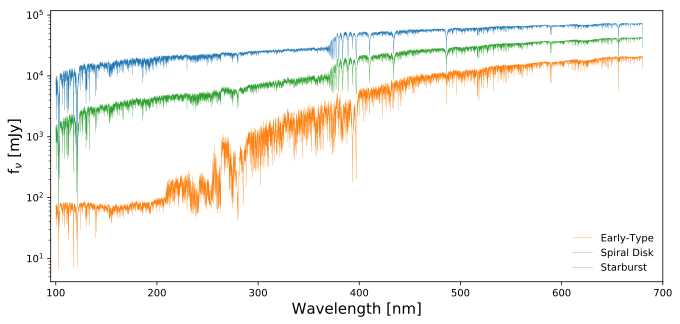

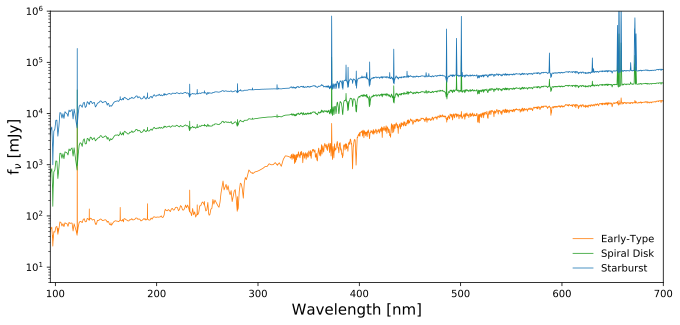

In [15]:
plt.figure()
plt.plot(*attenuated_star_emission_1, lw = 0.3, c = 'C1', label = 'Early-Type')
plt.plot(*attenuated_star_emission_2, lw = 0.3, c = 'C2', label = 'Spiral Disk')
plt.plot(*attenuated_star_emission_3, lw = 0.3, c = 'C0', label = 'Starburst')
plt.xlim(95, 700)
# plt.ylim(1e11, 3e15)
plt.yscale('log')
plt.xlabel('Wavelength [nm]', fontsize = 15)
plt.ylabel(r'f$_\nu$ [mJy]', fontsize = 15)
plt.legend(frameon = False, prop = {'size': 10}, markerscale = 1.3 , loc = 'lower right')

plt.figure()
plt.plot(*attenuated_star_emission_1_1, lw = 0.8, c = 'C1', label = 'Early-Type')
plt.plot(*attenuated_star_emission_2_2, lw = 0.8, c = 'C2', label = 'Spiral Disk')
plt.plot(*attenuated_star_emission_3_3, lw = 0.8, c = 'C0', label = 'Starburst')
plt.xlim(95, 700)
plt.ylim(5, 1e6)
plt.yscale('log')
plt.xlabel('Wavelength [nm]', fontsize = 15)
plt.ylabel(r'f$_\nu$ [mJy]', fontsize = 15)
plt.legend(frameon = False, prop = {'size': 10}, markerscale = 1.3 , loc = 'lower right')

# Cutting the wavelengths for M11 models in an autonomous way

# Redshifting

In [34]:
galaxy_copies_BC03 = [gal_1, gal_2, gal_3,\
                      gal_2_low, gal_3_low,\
                      gal_2_high, gal_3_high]

galaxy_copies_M11  = [gal_1_1, gal_2_2, gal_3_3,\
                      gal_2_2_low, gal_3_3_low,\
                      gal_2_2_high, gal_3_3_high]

# galaxy_copies = ['gal_1_redshifted', 'gal_2_redshifted', 'gal_3_redshifted',\
#                 'gal_1_1_redshifted', 'gal_1_2_redshifted', 'gal_1_3_redshifted',\
#                 'gal_2_low_redshifted', 'gal_3_low_redshifted',\
#                 'gal_2_2_low_redshifted', 'gal_3_3_low_redshifted',\
#                 'gal_2_high_redshifted', 'gal_3_high_redshifted',\
#                 'gal_2_2_high_redshifted', 'gal_3_3_high_redshifted', ]

In [58]:
# M11-models wavelength limits in nm
Lmin_M11 = 100.02
Lmax_M11 = 680.00

def Lobs(Lambda,redshift):
    return (Lambda*(redshift + 1.0))

def flux_lambda(flux_nu, wavelength):
    # Wavelength must be in nm
    # Flux_nu must be in mJy
    return((1.0/3.34e4)*(wavelength*10)**-2*(flux_nu*1e-3))

for i in range(len(galaxy_copies_BC03)):

    gal_copy_BC03_redshifted = deepcopy(galaxy_copies_BC03[i])
    gal_copy_M11_redshifted  = deepcopy(galaxy_copies_M11[i])
#     print(gal_copy_BC03_redshifted)
    
#     for j in np.arange(0.5, 6.5, 0.5):
    for j in np.arange(1.5, 2.0, 0.5):
        
        z_expected = j        
    
        # Redshifting M11 models
        mod_1_red = modules.get_module('redshifting', redshift=z_expected)
        mod_1_red.process(gal_copy_M11_redshifted)
        redshifted_1 = gal_copy_M11_redshifted.wavelength_grid, gal_copy_M11_redshifted.fnu
    
        # Redshifting BC03 models
        mod_1_1_red = modules.get_module('redshifting', redshift=z_expected)
        mod_1_1_red.process(gal_copy_BC03_redshifted)
        redshifted_1_1 = gal_copy_BC03_redshifted.wavelength_grid, gal_copy_BC03_redshifted.fnu
        
        # Cutting M11-models wavelength
        
        redshifted_1 = limit_spec(redshifted_1, Lobs(Lmin_M11, z_expected), Lobs(Lmax_M11, z_expected))
        
        # Unit conversion for flux and wavelength
        
        # Flux from mJy to erg cm^-2 s^-1 A^-1
        redshifted_1_flux   = flux_lambda(redshifted_1[1], redshifted_1[0])
        redshifted_1_1_flux = flux_lambda(redshifted_1_1[1], redshifted_1_1[0])
        # Flux from nm to Angstrom
        redshifted_1_wavelength  = 10*redshifted_1[0]
        redshifted_1_1wavelength = 10*redshifted_1_1[0]
        
        
#     plt.figure()
#     plt.plot(redshifted_1[0], redshifted_1[1], redshifted_1_1[0], redshifted_1_1[1], lw = 0.3)
    plt.plot(redshifted_1_wavelength, 3e10*redshifted_1_flux, redshifted_1_1wavelength, 3e10*redshifted_1_1_flux, lw = 0.3)
    plt.xlim(2500, 17000)
    plt.ylim(1e-21, 1e-17)
    plt.yscale('log')
    plt.xlabel('Wavelength [nm]', fontsize = 15)
    plt.ylabel(r'f$_\nu$ [mJy]', fontsize = 15)

In [23]:
def flux_lambda(flux_nu, wavelength):
    # Wavelength must be in nm
    # Flux_nu must be in mJy
    return((1.0/3.34e4)*(wavelength*10)**-2*(flux_nu*1e-3))

In [24]:
# Flux from mJy to erg cm^-2 s^-1 A^-1

redshifted_1_convolved        = flux_lambda(redshifted_1_convolved, redshifted_1[0])
redshifted_1_1_convolved      = flux_lambda(redshifted_1_1_convolved, redshifted_1_1[0])

redshifted_2_convolved        = flux_lambda(redshifted_2_convolved, redshifted_2[0])
redshifted_2_2_convolved      = flux_lambda(redshifted_2_2_convolved, redshifted_2_2[0])

redshifted_2_convolved_low    = flux_lambda(redshifted_2_convolved_low, redshifted_2_low[0])
redshifted_2_2_convolved_low  = flux_lambda(redshifted_2_2_convolved_low, redshifted_2_2_low[0])

redshifted_2_convolved_high   = flux_lambda(redshifted_2_convolved_high, redshifted_2_high[0])
redshifted_2_2_convolved_high = flux_lambda(redshifted_2_2_convolved_high, redshifted_2_2_high[0])

redshifted_3_convolved        = flux_lambda(redshifted_3_convolved, redshifted_3[0])
redshifted_3_3_convolved      = flux_lambda(redshifted_3_3_convolved, redshifted_3_3[0])

redshifted_3_convolved_low    = flux_lambda(redshifted_3_convolved_low, redshifted_3_low[0])
redshifted_3_3_convolved_low  = flux_lambda(redshifted_3_3_convolved_low, redshifted_3_3_low[0])

redshifted_3_convolved_high   = flux_lambda(redshifted_3_convolved_high, redshifted_3_high[0])
redshifted_3_3_convolved_high = flux_lambda(redshifted_3_3_convolved_high, redshifted_3_3_high[0])

# No colvolved data

This lines must be commented if one used the one above because the convolution comes before

In [25]:
# Flux from mJy to erg cm^-2 s^-1 A^-1

redshifted_1_noconvolved        = flux_lambda(redshifted_1[1], redshifted_1[0])
redshifted_1_1_noconvolved      = flux_lambda(redshifted_1_1[1], redshifted_1_1[0])

redshifted_2_noconvolved        = flux_lambda(redshifted_2[1], redshifted_2[0])
redshifted_2_2_noconvolved      = flux_lambda(redshifted_2_2[1], redshifted_2_2[0])

redshifted_2_noconvolved_low    = flux_lambda(redshifted_2_low[1], redshifted_2_low[0])
redshifted_2_2_noconvolved_low  = flux_lambda(redshifted_2_2_low[1], redshifted_2_2_low[0])

redshifted_2_noconvolved_high   = flux_lambda(redshifted_2_high[1], redshifted_2_high[0])
redshifted_2_2_noconvolved_high = flux_lambda(redshifted_2_2_high[1], redshifted_2_2_high[0])

redshifted_3_noconvolved        = flux_lambda(redshifted_3[1], redshifted_3[0])
redshifted_3_3_noconvolved      = flux_lambda(redshifted_3_3[1], redshifted_3_3[0])

redshifted_3_noconvolved_low    = flux_lambda(redshifted_3_low[1], redshifted_3_low[0])
redshifted_3_3_noconvolved_low  = flux_lambda(redshifted_3_3_low[1], redshifted_3_3_low[0])

redshifted_3_noconvolved_high   = flux_lambda(redshifted_3_high[1], redshifted_3_high[0])
redshifted_3_3_noconvolved_high = flux_lambda(redshifted_3_3_high[1], redshifted_3_3_high[0])

# Saving files as example for the Telecon

# Files after Convolution + Redshifting

In [26]:
# Saving files for the Early-Type Galaxy to show the example in the telecon

# Wavelength is multiplied by 10 to change from 'nm' to 'AA'

early_type_M11 = Table([10*redshifted_1[0],redshifted_1_convolved], names=('wavelength', 'flux'),\
                    dtype=('f8', 'f8'), meta={'name': 'early_type_convolved_redshifted'})
early_type_BC03 = Table([10*redshifted_1_1[0],redshifted_1_1_convolved], names=('wavelength', 'flux'),\
                    dtype=('f8', 'f8'), meta={'name': 'early_type_convolved_redshifted'})

early_type_M11.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/early_type_M11.fits', format = 'fits', overwrite = True)
early_type_BC03.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/early_type_BC03.fits', format = 'fits', overwrite = True)

# Saving files for the Disk Galaxy to show the example in the telecon

spiral_disk_M11 = Table([10*redshifted_2[0],redshifted_2_convolved], names=('wavelength', 'flux'),\
                    dtype=('f8', 'f8'), meta={'name': 'spiral_disk_convolved_redshifted'})
spiral_disk_BC03 = Table([10*redshifted_2_2[0],redshifted_2_2_convolved], names=('wavelength', 'flux'),\
                    dtype=('f8', 'f8'), meta={'name': 'spiral_disk_convolved_redshifted'})

spiral_disk_M11_lowAv = Table([10*redshifted_2_low[0],redshifted_2_convolved_low], names=('wavelength', 'flux'),\
                              dtype=('f8', 'f8'), meta={'name': 'spiral_disk_convolved_redshifted-lowAv'})
spiral_disk_BC03_lowAv = Table([10*redshifted_2_2_low[0],redshifted_2_2_convolved_low], names=('wavelength', 'flux'),\
                               dtype=('f8', 'f8'), meta={'name': 'spiral_disk_convolved_redshifted-lowAv'})

spiral_disk_M11_highAv = Table([10*redshifted_2_high[0],redshifted_2_convolved_high], names=('wavelength', 'flux'),\
                              dtype=('f8', 'f8'), meta={'name': 'spiral_disk_convolved_redshifted-highAv'})
spiral_disk_BC03_highAv = Table([10*redshifted_2_2_high[0],redshifted_2_2_convolved_high], names=('wavelength', 'flux'),\
                               dtype=('f8', 'f8'), meta={'name': 'spiral_disk_convolved_redshifted-highAv'})


spiral_disk_M11.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/spiral_disk_M11.fits', format = 'fits', overwrite = True)
spiral_disk_BC03.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/spiral_disk_BC03.fits', format = 'fits', overwrite = True)

spiral_disk_M11_lowAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/spiral_disk_M11_lowAv.fits', format = 'fits', overwrite = True)
spiral_disk_BC03_lowAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/spiral_disk_BC03_lowAv.fits', format = 'fits', overwrite = True)

spiral_disk_M11_highAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/spiral_disk_M11_highAv.fits', format = 'fits', overwrite = True)
spiral_disk_BC03_highAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/spiral_disk_BC03_highAv.fits', format = 'fits', overwrite = True)

# Saving files for the starburst Galaxy to show the example in the telecon

starburst_M11 = Table([10*redshifted_3[0],redshifted_3_convolved], names=('wavelength', 'flux'),\
                    dtype=('f8', 'f8'), meta={'name': 'starburst_convolved_redshifted'})
starburst_BC03 = Table([10*redshifted_3_3[0],redshifted_3_3_convolved], names=('wavelength', 'flux'),\
                    dtype=('f8', 'f8'), meta={'name': 'starburst_convolved_redshifted'})

starburst_M11_lowAv = Table([10*redshifted_3_low[0],redshifted_3_convolved_low], names=('wavelength', 'flux'),\
                              dtype=('f8', 'f8'), meta={'name': 'starburst_convolved_redshifted-lowAv'})
starburst_BC03_lowAv = Table([10*redshifted_3_3_low[0],redshifted_3_3_convolved_low], names=('wavelength', 'flux'),\
                               dtype=('f8', 'f8'), meta={'name': 'starburst_convolved_redshifted-lowAv'})

starburst_M11_highAv = Table([10*redshifted_3_high[0],redshifted_3_convolved_high], names=('wavelength', 'flux'),\
                              dtype=('f8', 'f8'), meta={'name': 'starburst_convolved_redshifted-highAv'})
starburst_BC03_highAv = Table([10*redshifted_3_3_high[0],redshifted_3_3_convolved_high], names=('wavelength', 'flux'),\
                               dtype=('f8', 'f8'), meta={'name': 'starburst_convolved_redshifted-highAv'})


starburst_M11.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/starburst_M11.fits', format = 'fits', overwrite = True)
starburst_BC03.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/starburst_BC03.fits', format = 'fits', overwrite = True)

starburst_M11_lowAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/starburst_M11_lowAv.fits', format = 'fits', overwrite = True)
starburst_BC03_lowAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/starburst_BC03_lowAv.fits', format = 'fits', overwrite = True)

starburst_M11_highAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/starburst_M11_highAv.fits', format = 'fits', overwrite = True)
starburst_BC03_highAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/starburst_BC03_highAv.fits', format = 'fits', overwrite = True)

# Saving files with R = 20000 for ETC without any convolution

# Only redshifted. No convolution performed!

In [27]:
# Saving files for the Early-Type Galaxy to show the example in the telecon

# Wavelength is multiplied by 10 to change from 'nm' to 'AA'

early_type_M11 = Table([10*redshifted_1[0],redshifted_1_noconvolved], names=('wavelength', 'flux'),\
                    dtype=('f8', 'f8'), meta={'name': 'early_type_noconvolved_redshifted'})
early_type_BC03 = Table([10*redshifted_1_1[0],redshifted_1_1_noconvolved], names=('wavelength', 'flux'),\
                    dtype=('f8', 'f8'), meta={'name': 'early_type_noconvolved_redshifted'})

early_type_M11.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/early_type_M11_noconvolved.fits', format = 'fits', overwrite = True)
early_type_BC03.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/early_type_BC03_noconvolved.fits', format = 'fits', overwrite = True)

# Saving files for the Disk Galaxy to show the example in the telecon

spiral_disk_M11 = Table([10*redshifted_2[0],redshifted_2_noconvolved], names=('wavelength', 'flux'),\
                    dtype=('f8', 'f8'), meta={'name': 'spiral_disk_noconvolved_redshifted'})
spiral_disk_BC03 = Table([10*redshifted_2_2[0],redshifted_2_2_noconvolved], names=('wavelength', 'flux'),\
                    dtype=('f8', 'f8'), meta={'name': 'spiral_disk_noconvolved_redshifted'})

spiral_disk_M11_lowAv = Table([10*redshifted_2_low[0],redshifted_2_noconvolved_low], names=('wavelength', 'flux'),\
                              dtype=('f8', 'f8'), meta={'name': 'spiral_disk_noconvolved_redshifted-lowAv'})
spiral_disk_BC03_lowAv = Table([10*redshifted_2_2_low[0],redshifted_2_2_noconvolved_low], names=('wavelength', 'flux'),\
                               dtype=('f8', 'f8'), meta={'name': 'spiral_disk_noconvolved_redshifted-lowAv'})

spiral_disk_M11_highAv = Table([10*redshifted_2_high[0],redshifted_2_noconvolved_high], names=('wavelength', 'flux'),\
                              dtype=('f8', 'f8'), meta={'name': 'spiral_disk_noconvolved_redshifted-highAv'})
spiral_disk_BC03_highAv = Table([10*redshifted_2_2_high[0],redshifted_2_2_noconvolved_high], names=('wavelength', 'flux'),\
                               dtype=('f8', 'f8'), meta={'name': 'spiral_disk_noconvolved_redshifted-highAv'})


spiral_disk_M11.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/spiral_disk_M11_noconvolved.fits', format = 'fits', overwrite = True)
spiral_disk_BC03.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/spiral_disk_BC03_noconvolved.fits', format = 'fits', overwrite = True)

spiral_disk_M11_lowAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/spiral_disk_M11_lowAv_noconvolved.fits', format = 'fits', overwrite = True)
spiral_disk_BC03_lowAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/spiral_disk_BC03_lowAv_noconvolved.fits', format = 'fits', overwrite = True)

spiral_disk_M11_highAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/spiral_disk_M11_highAv_noconvolved.fits', format = 'fits', overwrite = True)
spiral_disk_BC03_highAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/spiral_disk_BC03_highAv_noconvolved.fits', format = 'fits', overwrite = True)

# Saving files for the starburst Galaxy to show the example in the telecon

starburst_M11 = Table([10*redshifted_3[0],redshifted_3_noconvolved], names=('wavelength', 'flux'),\
                    dtype=('f8', 'f8'), meta={'name': 'starburst_noconvolved_redshifted'})
starburst_BC03 = Table([10*redshifted_3_3[0],redshifted_3_3_noconvolved], names=('wavelength', 'flux'),\
                    dtype=('f8', 'f8'), meta={'name': 'starburst_noconvolved_redshifted'})

starburst_M11_lowAv = Table([10*redshifted_3_low[0],redshifted_3_noconvolved_low], names=('wavelength', 'flux'),\
                              dtype=('f8', 'f8'), meta={'name': 'starburst_noconvolved_redshifted-lowAv'})
starburst_BC03_lowAv = Table([10*redshifted_3_3_low[0],redshifted_3_3_noconvolved_low], names=('wavelength', 'flux'),\
                               dtype=('f8', 'f8'), meta={'name': 'starburst_noconvolved_redshifted-lowAv'})

starburst_M11_highAv = Table([10*redshifted_3_high[0],redshifted_3_noconvolved_high], names=('wavelength', 'flux'),\
                              dtype=('f8', 'f8'), meta={'name': 'starburst_noconvolved_redshifted-highAv'})
starburst_BC03_highAv = Table([10*redshifted_3_3_high[0],redshifted_3_3_noconvolved_high], names=('wavelength', 'flux'),\
                               dtype=('f8', 'f8'), meta={'name': 'starburst_noconvolved_redshifted-highAv'})


starburst_M11.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/starburst_M11_noconvolved.fits', format = 'fits', overwrite = True)
starburst_BC03.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/starburst_BC03_noconvolved.fits', format = 'fits', overwrite = True)

starburst_M11_lowAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/starburst_M11_lowAv_noconvolved.fits', format = 'fits', overwrite = True)
starburst_BC03_lowAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/starburst_BC03_lowAv_noconvolved.fits', format = 'fits', overwrite = True)

starburst_M11_highAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/starburst_M11_highAv_noconvolved.fits', format = 'fits', overwrite = True)
starburst_BC03_highAv.write('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/starburst_BC03_highAv_noconvolved.fits', format = 'fits', overwrite = True)

# Saving special HEADER in the fits file

In [25]:
files = ['early_type_M11', 'spiral_disk_M11_highAv', 'starburst_M11_highAv'] 

for i in files:
    
    file = fits.open('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/'+str(i)+'.fits')
    
    hdr = file[0].header
    
    hdr.insert(4, ('CODE', 'Cigale', 'Simulation code'))
    hdr.insert(5, ('MTYPE', 'Galaxy', 'Star, Galaxy, or Quasar'))
    hdr.insert(6, ('MNAME', str(i)+'_convolved', 'Model name'))
    hdr.insert(7, ('CRVAL', 'CRVAL'))
    hdr.insert(8, ('CRDEL', 'CRDEL'))
    hdr.insert(9, ('CRPIX', 1))
    hdr.insert(10, ('R', 20000))
    hdr.insert(11, ('Sampling', '2. #Pixels per element of resolution'))
    hdr.insert(12, ('TUNIT1', 'nm'))
    hdr.insert(13, ('TUNIT2', 'erg/s/cm2/A'))
    
    file.writeto('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/'+str(i)+'_newtable.fits', overwrite = True)

In [28]:
T = fits.open('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/spiral_disk_M11_highAv_newtable.fits')
hdr = T[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
CODE    = 'Cigale  '           / Simulation code                                
MTYPE   = 'Galaxy  '           / Star, Galaxy, or Quasar                        
MNAME   = 'spiral_disk_M11_highAv_convolved' / Model name                       
CRVAL   = 'CRVAL   '                                                            
CRDEL   = 'CRDEL   '                                                            
CRPIX   =                    1                                                  
R       =                20000                                                  
SAMPLING= '2. #Pixels per element of resolution'                                
TUNIT1  = 'nm      '        

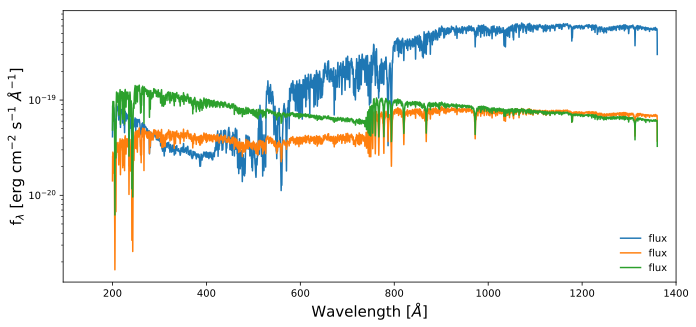

In [30]:
plt.figure()
for i in files:
    file = Table.read('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
                  'Galaxy_Samples/'+str(i)+'_newtable.fits', format = 'fits')
#     file_1 = Table.read('/home/jvilla/Documents/PhD_2018/MOONS-project/CIGALE-notebook/'
#                   'Galaxy_Samples/'+str(i)+'.fits', format = 'fits')    
    plt.plot(file['wavelength'], file['flux'])
#     plt.plot(file_1['wavelength'], file_1['flux'])
plt.xlim(95, 1400)
plt.yscale('log')
plt.xlabel('Wavelength [$\AA$]', fontsize = 15)
plt.ylabel(r'f$_\lambda$ [erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]', fontsize = 15)
plt.legend(frameon = False, prop = {'size': 10}, markerscale = 1.3 , loc = 'lower right')

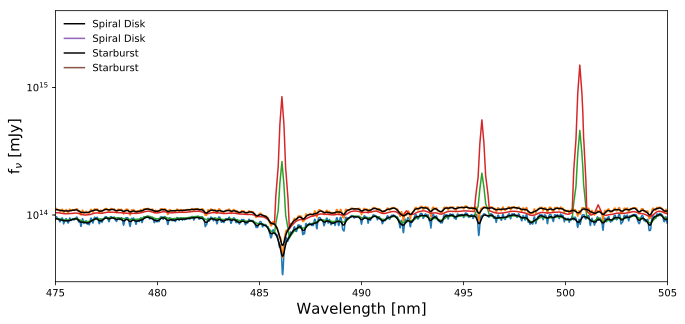

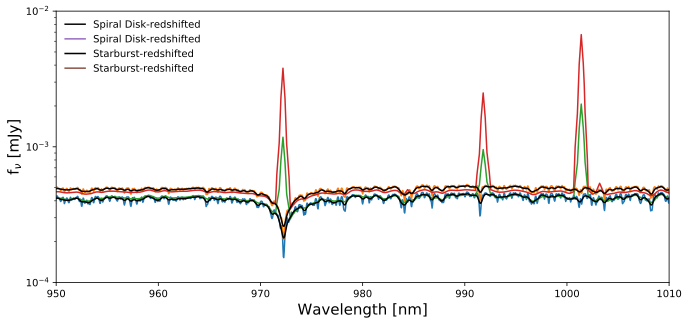

In [31]:
plt.figure()
plt.plot(*attenuated_star_emission_2)
plt.plot(*attenuated_star_emission_3)
plt.plot(*attenuated_star_emission_2_2)
plt.plot(*attenuated_star_emission_3_3)
plt.plot(attenuated_star_emission_2[0],attenuated_star_emission_2_convolved, 'k', '--', label = 'Spiral Disk')
plt.plot(attenuated_star_emission_3[0],attenuated_star_emission_3_convolved, 'k', '--', label = 'Starburst')
plt.xlim(475, 505)
plt.ylim(3e13, 4e15)
plt.yscale('symlog')
plt.xlabel('Wavelength [nm]', fontsize = 15)
plt.ylabel(r'f$_\nu$ [mJy]', fontsize = 15)
plt.legend(frameon = False, prop = {'size': 10}, markerscale = 1.3 , loc = 'upper left')

plt.figure()
plt.plot(*redshifted_2)
plt.plot(*redshifted_3)
plt.plot(*redshifted_2_2)
plt.plot(*redshifted_3_3)
plt.plot(redshifted_2[0],redshifted_2_convolved, 'k', '--', label = 'Spiral Disk-redshifted')
plt.plot(redshifted_3[0],redshifted_3_convolved, 'k', '--', label = 'Starburst-redshifted')
plt.xlim(950, 1010)
plt.ylim(1e-4, 1e-2)
plt.yscale('log')
plt.xlabel('Wavelength [nm]', fontsize = 15)
plt.ylabel(r'f$_\nu$ [mJy]', fontsize = 15)
plt.legend(frameon = False, prop = {'size': 10}, markerscale = 1.3 , loc = 'upper left')